In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [3]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 685 ms, sys: 144 ms, total: 829 ms
Wall time: 3.73 s


In [4]:
df = df[~df['Finding Labels'].str.contains('\|')]

In [5]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

In [6]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.png'))}        
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

In [7]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)

In [8]:
df_1 = pd.concat([df[df['Finding Labels'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Finding Labels'] == 'Tuberculosis'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Finding Labels'] == 'Emphysema'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Finding Labels'] == 'Covid'].sample(500, random_state=42)])
df_5 = pd.concat([df[df['Finding Labels'] == 'Pneumonia'].sample(500, random_state=42)])

df = pd.concat([df_1,df_2,df_3,df_4, df_5])
df = df.reset_index(drop=True)

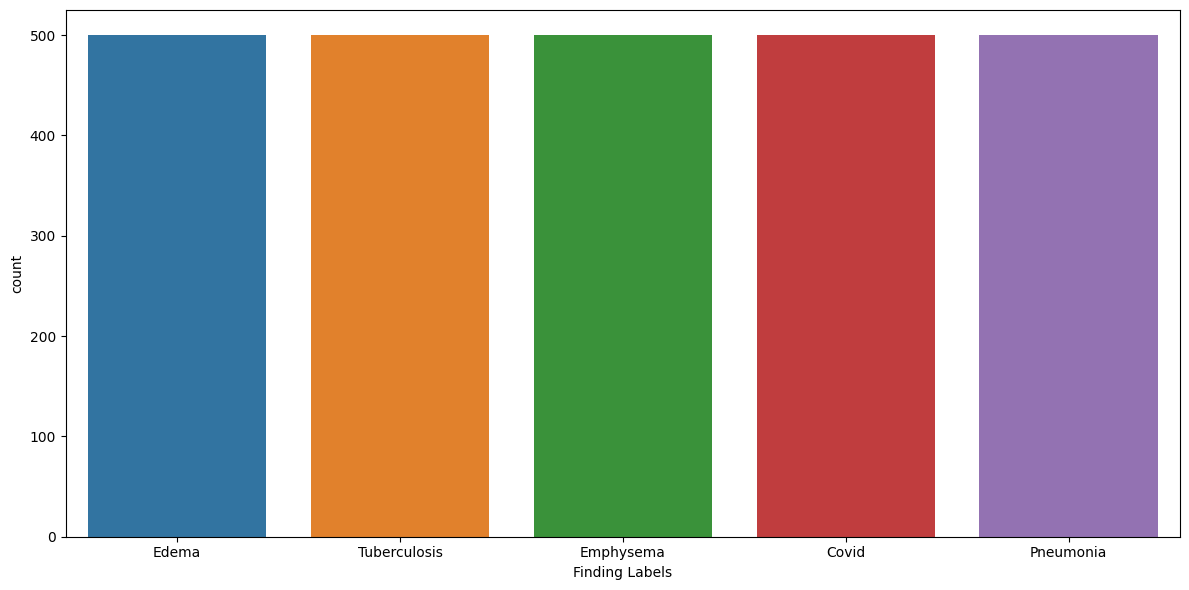

In [9]:
plt.figure(figsize=(12,6))

sns.countplot(x=df['Finding Labels'])

plt.tight_layout()
plt.show()

In [10]:
import shutil

In [11]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00026971_005.png,Edema,5.0,26971.0,44.0,M,AP,3056.0,2544.0,0.139,0.139,/kaggle/input/data/images_011/images/00026971_...
1,00027415_012.png,Edema,12.0,27415.0,23.0,M,AP,3056.0,2544.0,0.139,0.139,/kaggle/input/data/images_011/images/00027415_...
2,00023310_005.png,Edema,5.0,23310.0,42.0,F,AP,3056.0,2544.0,0.139,0.139,/kaggle/input/data/images_010/images/00023310_...
3,00011985_005.png,Edema,5.0,11985.0,54.0,F,AP,2500.0,2048.0,0.168,0.168,/kaggle/input/data/images_006/images/00011985_...
4,00018972_049.png,Edema,49.0,18972.0,52.0,F,AP,2500.0,2048.0,0.168,0.168,/kaggle/input/data/images_009/images/00018972_...
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,person95_virus_177.jpeg,Pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2496,00003640_004.png,Pneumonia,4.0,3640.0,45.0,M,PA,2992.0,2991.0,0.143,0.143,/kaggle/input/data/images_002/images/00003640_...
2497,person125_virus_254.jpeg,Pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2498,person688_virus_1281.jpeg,Pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [12]:
df.to_csv('metadata.csv', index=False)

In [13]:
PATH = '/kaggle/working/Bbox/'

for label in df['Finding Labels'].unique():
    os.makedirs(os.path.join(PATH,label), exist_ok=True)
    
    tmp = df[df['Finding Labels'] == label].reset_index(drop=True)
    
    for file in tqdm(tmp['path'].unique()):
        shutil.copy(file, os.path.join(PATH,label))

100%|██████████| 500/500 [00:04<00:00, 123.62it/s]
